<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

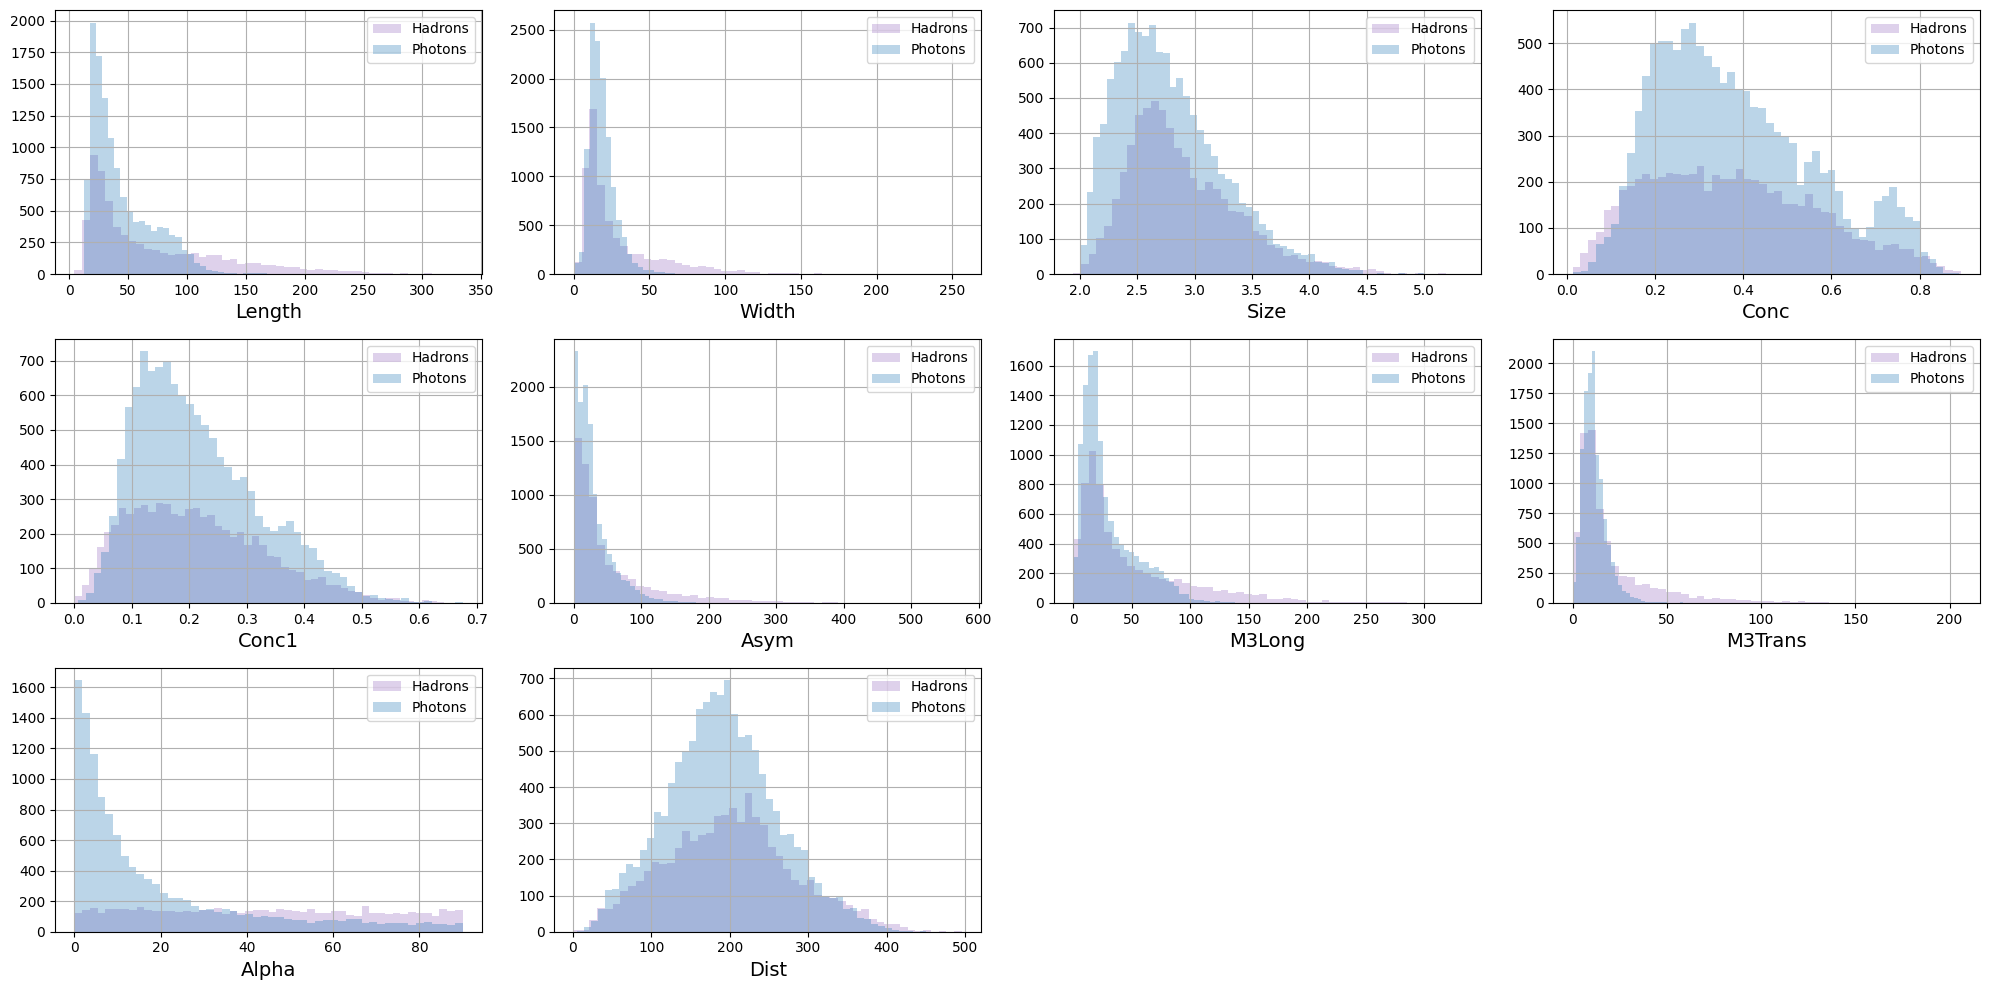

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

In [ ]:
# причесываем немного данные, чтобы легко отобразить в готовой функции

zero_train = y_train[y_train == 0]
zero_train = zero_train.reshape(zero_train.shape[0], 1)
one_train = y_train[y_train == 1]
one_train = one_train.reshape(one_train.shape[0], 1)

zero_test = y_test[y_test == 0]
zero_test = zero_test.reshape(zero_test.shape[0], 1)
one_test = y_test[y_test == 1]
one_test = one_test.reshape(one_test.shape[0], 1)

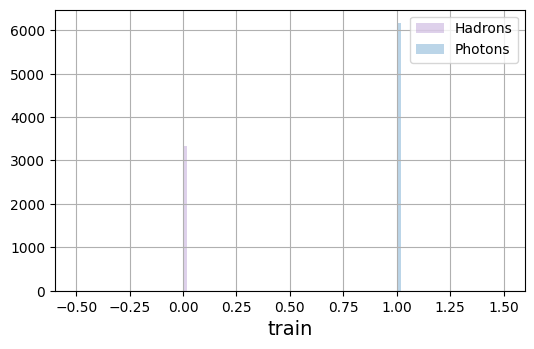

In [ ]:
plot_hists(
    zero_train, one_train, ['train'], label1="Hadrons", label2="Photons", bins=50
)

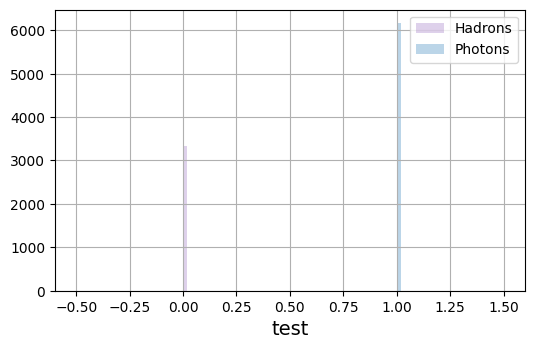

In [ ]:
plot_hists(
    zero_test, one_test, ['test'], label1="Hadrons", label2="Photons", bins=50
)

Адронов меньше в 2 раза и в тестовой, и в тренировочной выборке. Рзамеры выборок одинаковые, количественные отношения адронов к фотонам тоже одинаковые между двумя выборками

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution = 'normal')
qt.fit(X_train)
X_train = qt.transform(X_train)
X_test = qt.transform(X_test)

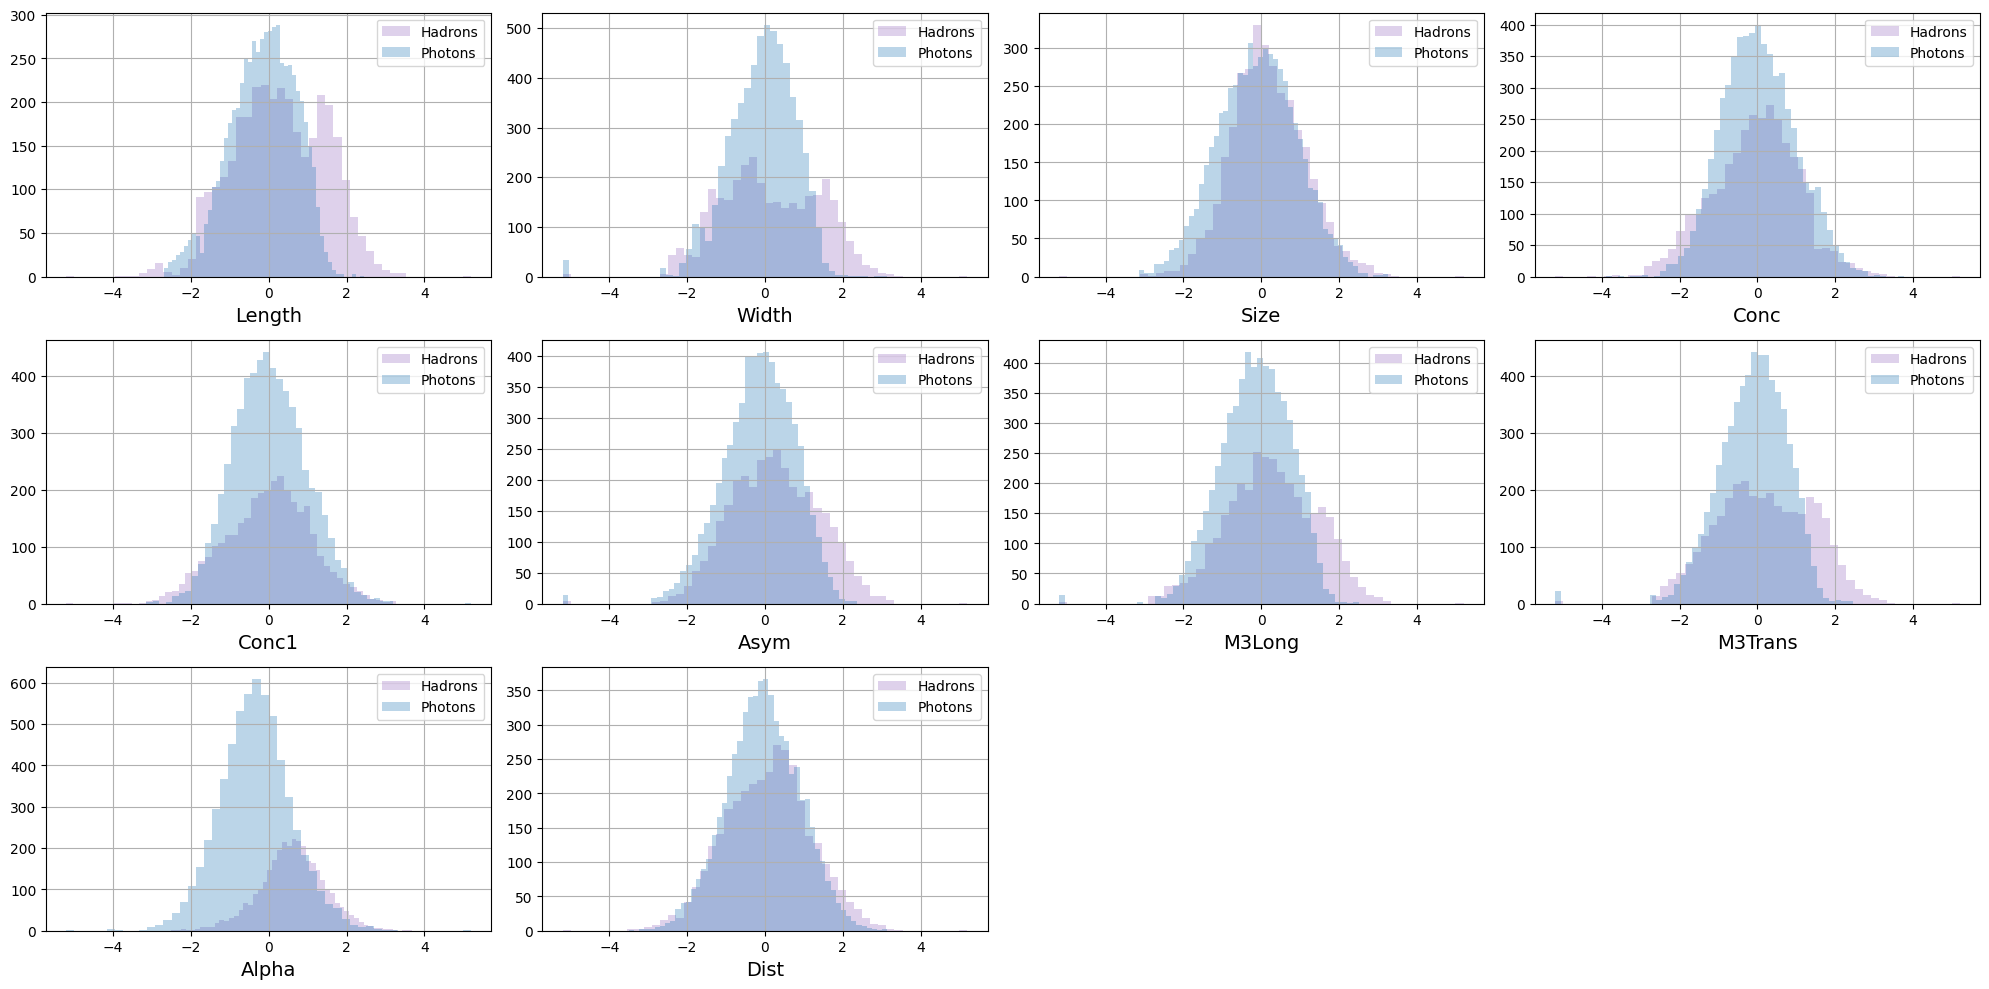

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

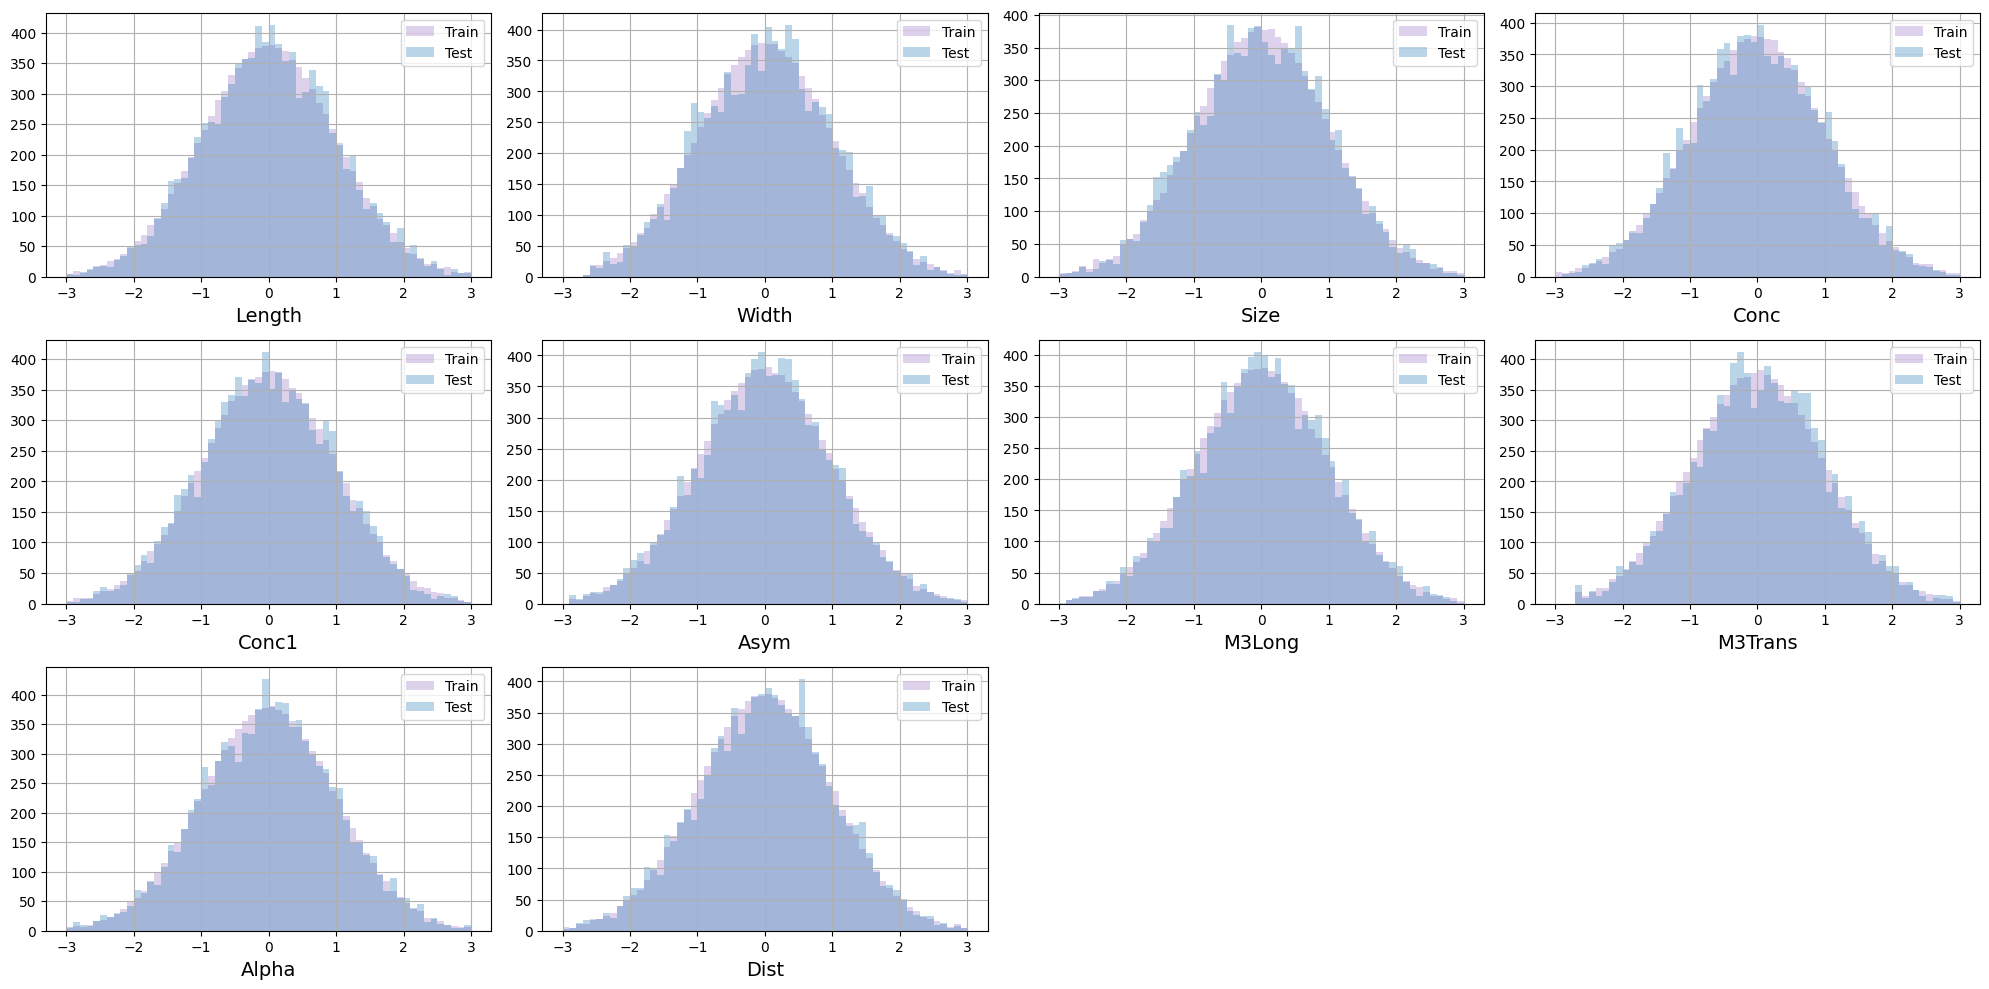

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        ### YOUR CODE IS HERE ######

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [ ]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######

    prior = torch.distributions.Normal(torch.zeros(latent_dim).to(DEVICE), torch.ones(latent_dim).to(DEVICE))
    z = prior.sample((y.shape[0],))

    y = torch.tensor(y, dtype=torch.float, device=DEVICE) # костыль, решающий множество проблем
    X_fake = generator.forward(z, y)

    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

Нужно, чтобы нейросеть классифицировала реальный ли это был объект или фейковый, поэтому в конце нужно привести ответ к диапазону (0, 1) и дальше уже обрабатывать эти ответы для правильного подсчета ошибки и т.д. По-классике, юзанем сигмоиду

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [ ]:
from sklearn.linear_model import LogisticRegression

!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 10.0 MB/s eta 0:00:00


In [ ]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######

    X_real = np.concatenate((X_real, y_real), axis = 1)
    X_fake = np.concatenate((X_fake, y_fake), axis = 1)
    X = np.concatenate((X_real, X_fake), axis = 0)

    y_real = np.ones((X_real.shape[0], 1))
    y_fake = np.zeros((X_fake.shape[0], 1))
    y = np.concatenate((y_real, y_fake), axis = 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

    lin = LogisticRegression()
    lin.fit(X_train, y_train)
    lin_reg_score = accuracy_score(lin.predict(X_test), y_test)

    boost = CatBoostClassifier()
    boost.fit(X_train, y_train)
    boosting_score = accuracy_score(boost.predict(X_test), y_test)

    ### THE END OF YOUR CODE ###
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

По логике, модели должны хорошо определять, когда объекты настоящие, и не угадать, когда они фейковые. Поэтому все что 0, модель должна выдать как 1. Тогда accuracy должна быть 0.75 (так как 3 к 1)

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):

                ### YOUR CODE IS HERE ######
                fake_batch = self.generator(torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE), cond_batch)

                if i % self.n_critic == 0:
                  # делаем шаг обучения генератора

                  self.opt_gen.zero_grad()
                  gen_loss = torch.mean(self.discriminator(real_batch, cond_batch)) - torch.mean(self.discriminator(fake_batch, cond_batch))
                  gen_loss.backward()
                  self.opt_gen.step()

                else:
                  # делаем шаг обучения дискриминатора

                  self.opt_disc.zero_grad()
                  discr_loss = torch.mean(self.discriminator(fake_batch, cond_batch)) - torch.mean(self.discriminator(real_batch, cond_batch))
                  discr_loss.backward()
                  self.opt_disc.step()

                  #Clipping weights
                  for p in self.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######

        indices = np.random.choice(X.shape[0], 1000, replace = False)
        cond = y[indices]


        X_gen = generate(self.generator, cond, X.shape[1])
        other_agent_score(X[indices], cond, X_gen.detach().cpu(), cond)
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

Все что юзал с ресурсов:

[https://stackoverflow.com/questions/61390166/wasserstein-gan-implemtation-in-pytorch-how-to-implement-the-loss](https://)

## Обучение
Обучим модель на данных.

In [ ]:
#%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.01225
0:	learn: 0.6925741	total: 7.34ms	remaining: 7.33s
1:	learn: 0.6918824	total: 13.4ms	remaining: 6.68s
2:	learn: 0.6912829	total: 20.7ms	remaining: 6.89s
3:	learn: 0.6910073	total: 27.3ms	remaining: 6.81s
4:	learn: 0.6902572	total: 30.4ms	remaining: 6.04s
5:	learn: 0.6897672	total: 44.3ms	remaining: 7.34s
6:	learn: 0.6892084	total: 52.5ms	remaining: 7.45s
7:	learn: 0.6885419	total: 55.3ms	remaining: 6.85s
8:	learn: 0.6880155	total: 64ms	remaining: 7.05s
9:	learn: 0.6873800	total: 66.8ms	remaining: 6.61s
10:	learn: 0.6867691	total: 69.6ms	remaining: 6.26s
11:	learn: 0.6862957	total: 72.3ms	remaining: 5.95s
12:	learn: 0.6859125	total: 74.9ms	remaining: 5.68s
13:	learn: 0.6854258	total: 77.5ms	remaining: 5.46s
14:	learn: 0.6848042	total: 80.1ms	remaining: 5.26s
15:	learn: 0.6841442	total: 88.3ms	remaining: 5.43s
16:	learn: 0.6833592	total: 91.5ms	remaining: 5.29s
17:	learn: 0.6830655	total: 94.4ms	remaining: 5.15s
18:	learn: 0.6824132	total: 98.7ms	remaining: 5

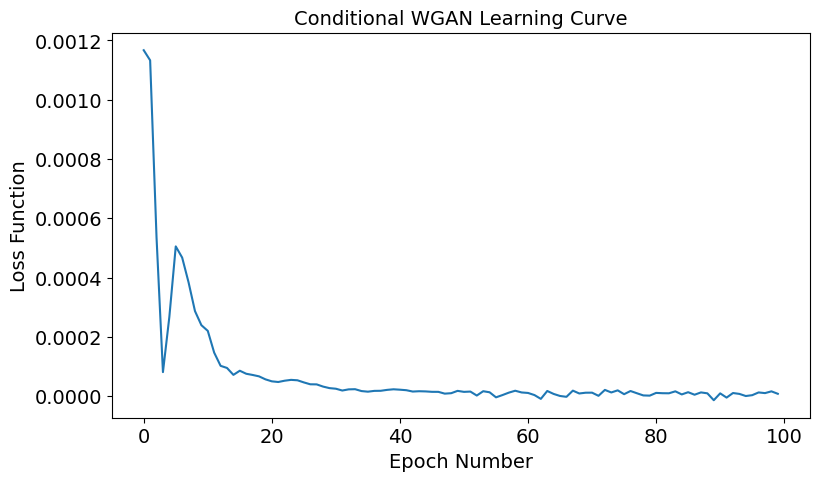

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [ ]:
### YOUR CODE IS HERE ######
X_train_original = qt.inverse_transform(X_train)
X_test_original = qt.inverse_transform(X_test)
### THE END OF YOUR CODE ###

In [ ]:
X_fake_train = generate(fitter.generator, y_train, latent_dim).detach().cpu()
X_fake_train = qt.inverse_transform(X_fake_train)

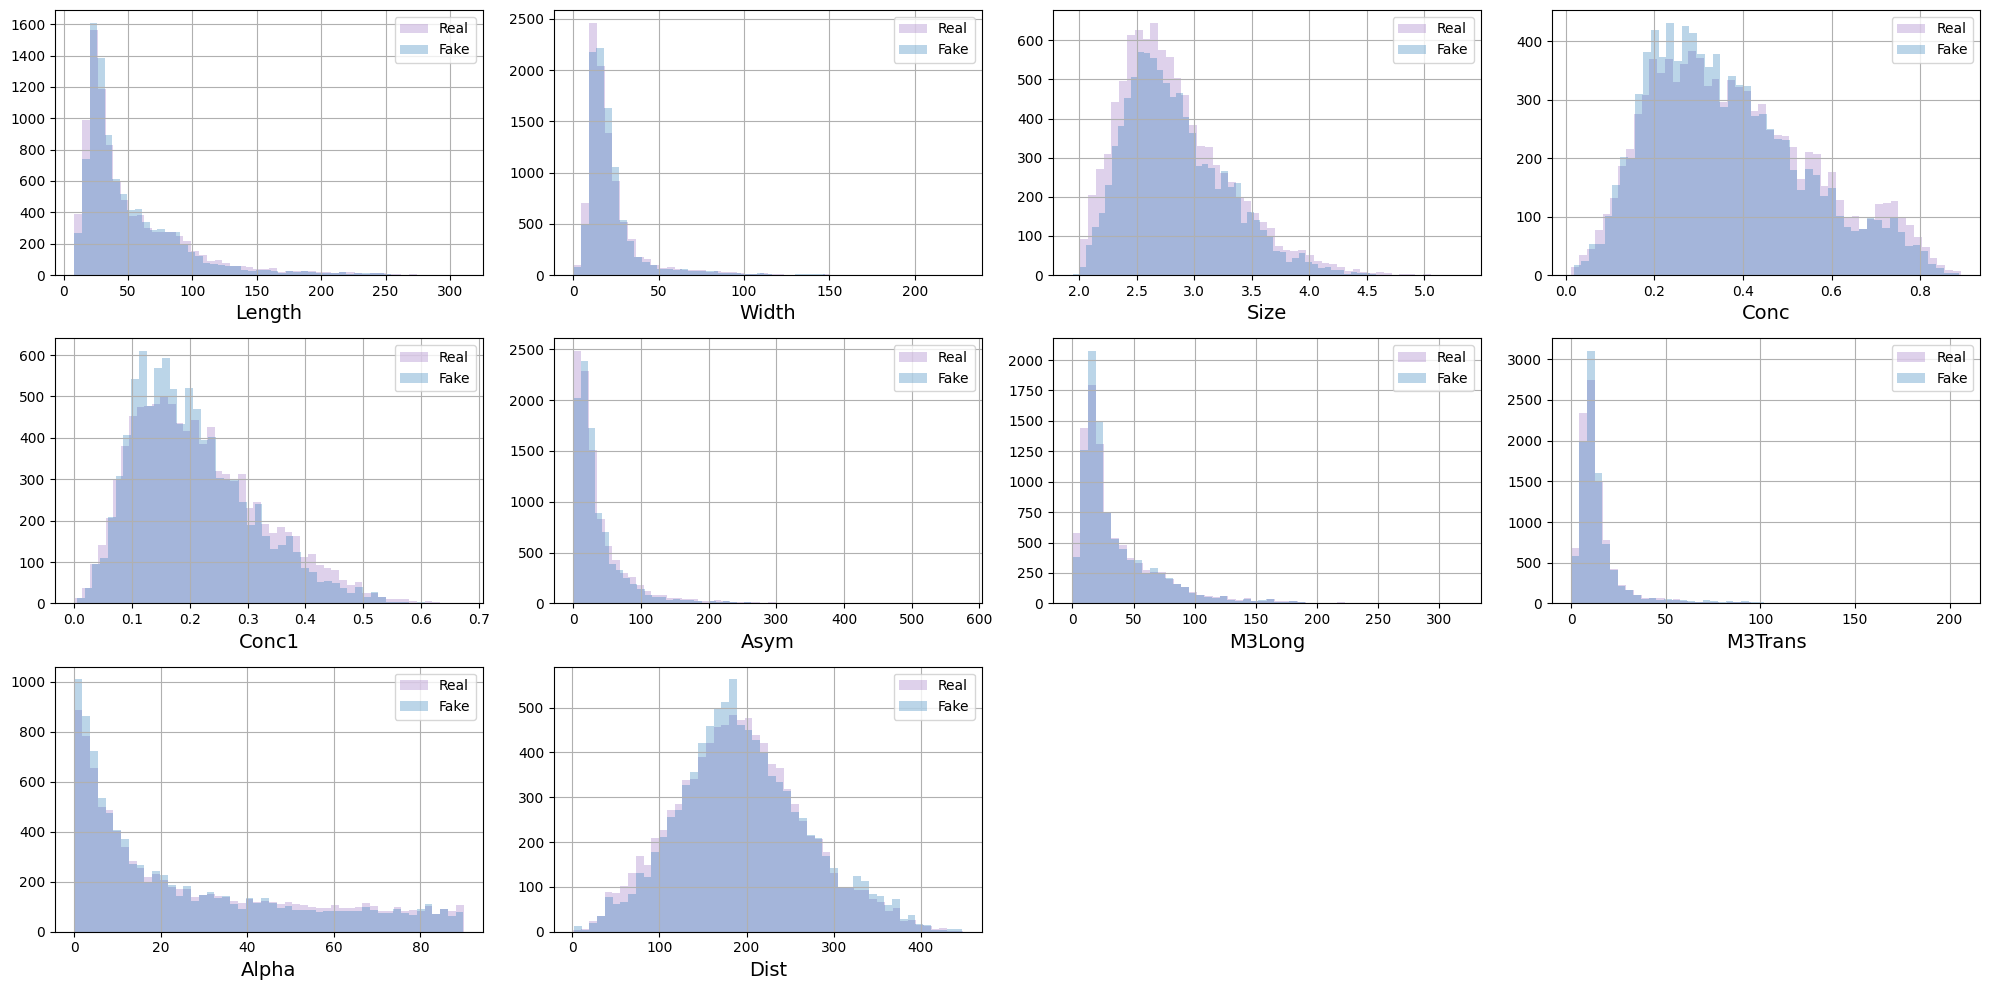

In [ ]:
plot_hists(X_train_original, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test = generate(fitter.generator, y_test, latent_dim).detach().cpu()
X_fake_test = qt.inverse_transform(X_fake_test)

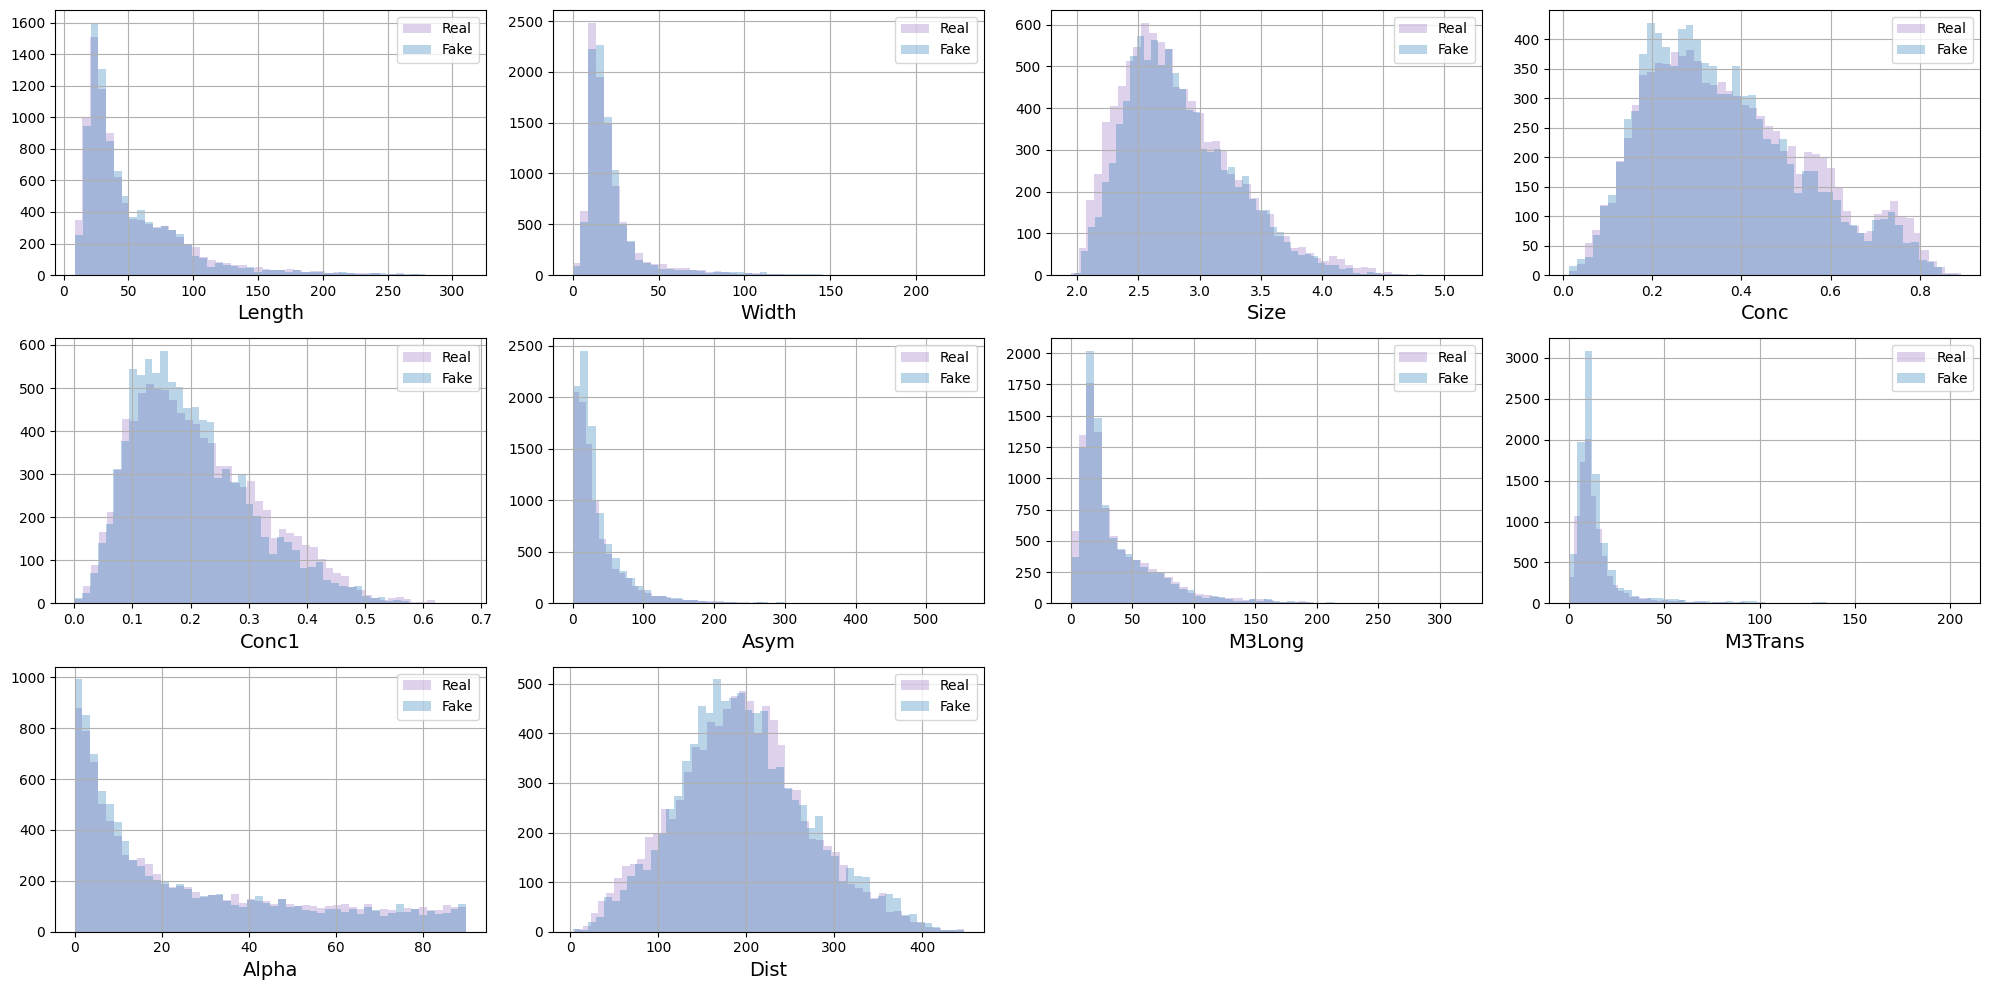

In [ ]:
plot_hists(X_test_original, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_original), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_original), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_original))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_original))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.703579960659044


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Мы обучили модель, которая нагенерировала новые объекты. Эти объекты бустинг может отличать, но с хорошим трудом. ROC AUC =  0.7. Я считаю, что это хороший результат. При ROC AUC = 0.5 модель вообще не может отличать реальный ли объект или нет (0.5 - модель одинаково ошибается при классификации правильных объектов и неравильных). То есть к этому значению мы и должны стараться приблизиться.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [ ]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.rand_like(x).to(DEVICE)
    amount = amount.view(-1, 1)
    x = x * (1 - amount) + noise * amount
    ### THE END OF YOUR CODE ###
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [ ]:
!pip install diffusers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.4 MB/s eta 0:00:00


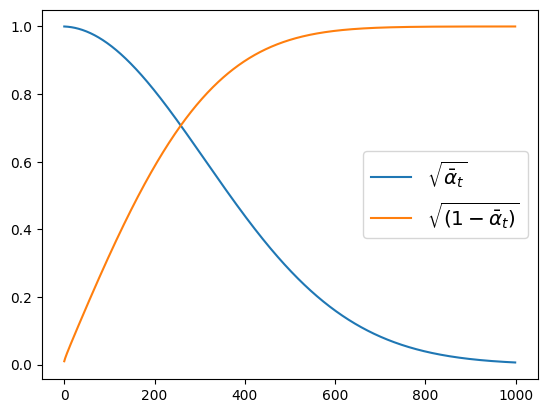

In [ ]:
from diffusers import DDPMScheduler
from tqdm.auto import tqdm

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, timesteps):
    ### YOUR CODE IS HERE ######

    X_fake = torch.randn(y.shape[0], latent_dim).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float, device=DEVICE) # костыль, решающий множество проблем

    for i in range(timesteps):

      with torch.no_grad():

        pred = model.forward(X_fake, y)  # Again, note that we pass in our labels y
        mix_factor = 1 / (timesteps - i)
        X_fake = X_fake * (1 - mix_factor) + pred * mix_factor


    ### THE END OF YOUR CODE ###
    return X_fake.detach().cpu()  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
        timesteps = 1000,
        scheduler=None
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.timesteps = timesteps

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

        self.scheduler = scheduler # буду использовать шедулер для зашумления

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                noise = torch.randn(real_batch.shape[0]).to(DEVICE)

                noisy_real_batch = corrupt(real_batch, noise)

                pred = self.model(noisy_real_batch, cond_batch)  # Note that we pass in the labels y скорее всего я еще timestamps передам скоро.......

                loss = self.loss_fn(pred, real_batch)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()


                loss_epoch += loss

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(torch.mean(loss_epoch).detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
        indices = np.random.choice(X.shape[0], 1000, replace = False)
        cond = y[indices]

        X_gen = generate_with_diffusion(self.model, cond, self.latent_dim, self.timesteps)
        other_agent_score(X[indices], cond, X_gen.detach().cpu(), cond)
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
)
diffusionFitter.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.01225
0:	learn: 0.6909897	total: 6.79ms	remaining: 6.78s
1:	learn: 0.6882437	total: 13.5ms	remaining: 6.74s
2:	learn: 0.6858978	total: 20.6ms	remaining: 6.84s
3:	learn: 0.6832094	total: 27.2ms	remaining: 6.78s
4:	learn: 0.6807065	total: 34.4ms	remaining: 6.85s
5:	learn: 0.6789088	total: 40.9ms	remaining: 6.77s
6:	learn: 0.6761165	total: 43.9ms	remaining: 6.22s
7:	learn: 0.6737380	total: 46.8ms	remaining: 5.8s
8:	learn: 0.6713305	total: 50ms	remaining: 5.5s
9:	learn: 0.6691473	total: 53.2ms	remaining: 5.27s
10:	learn: 0.6663121	total: 56.3ms	remaining: 5.07s
11:	learn: 0.6638410	total: 59.7ms	remaining: 4.91s
12:	learn: 0.6618524	total: 63ms	remaining: 4.79s
13:	learn: 0.6597265	total: 66.2ms	remaining: 4.66s
14:	learn: 0.6576060	total: 69.4ms	remaining: 4.56s
15:	learn: 0.6552013	total: 72.8ms	remaining: 4.48s
16:	learn: 0.6531384	total: 76.3ms	remaining: 4.41s
17:	learn: 0.6514118	total: 79.5ms	remaining: 4.33s
18:	learn: 0.6488489	total: 82.6ms	remaining: 4.26s

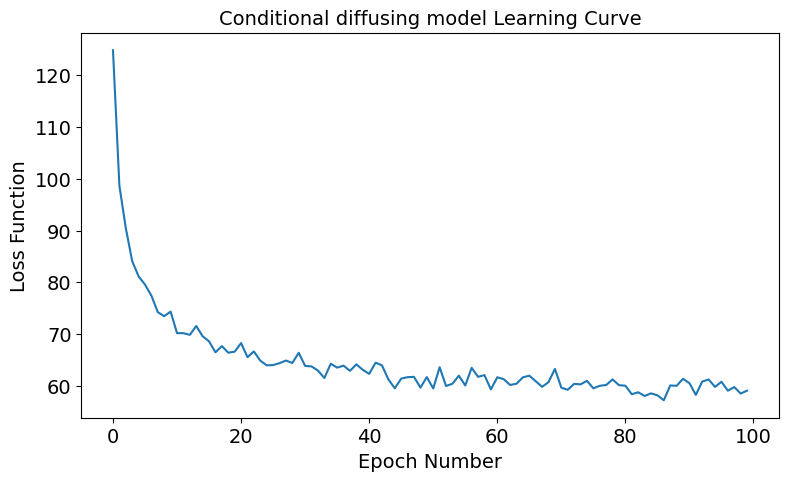

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [ ]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, 1000).detach().cpu()
X_fake_train = qt.inverse_transform(X_fake_train)

X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, 1000).detach().cpu()
X_fake_test = qt.inverse_transform(X_fake_test)

# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_original), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_original), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_original))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_original))

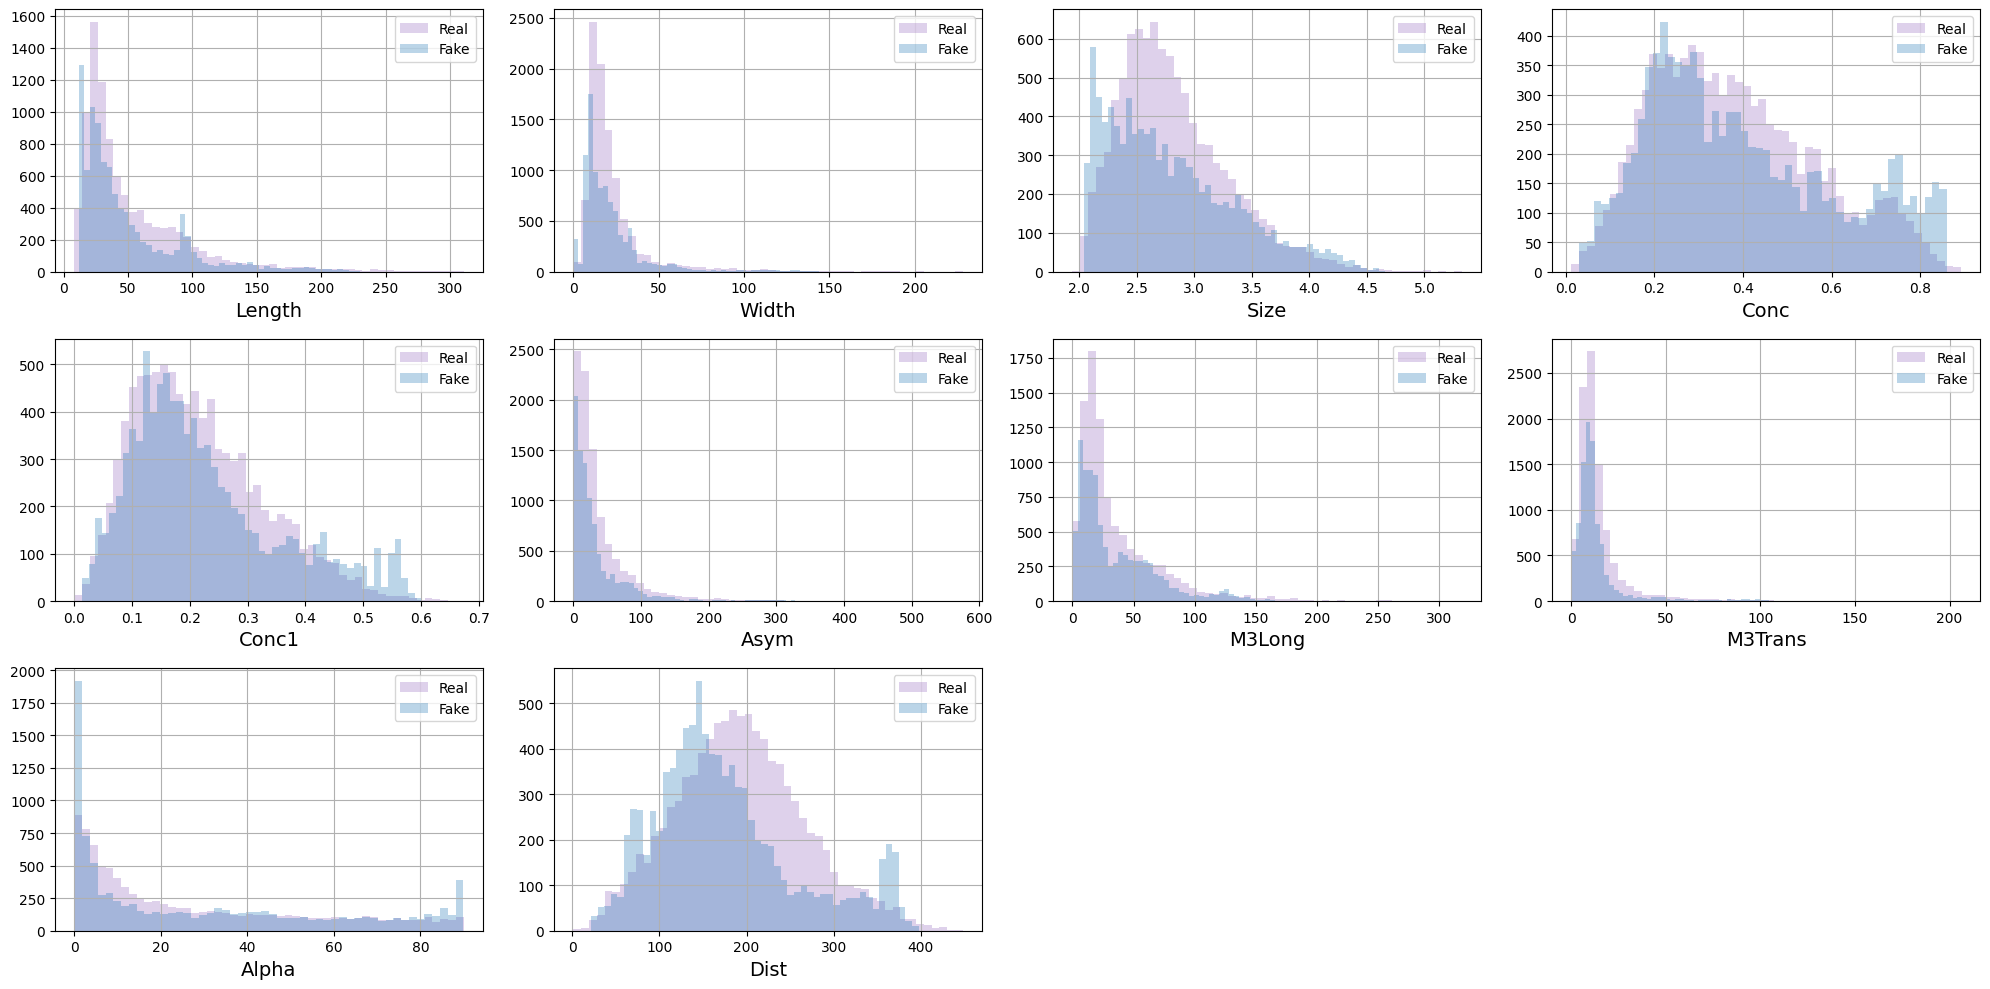

In [ ]:
plot_hists(X_train_original, X_fake_train, names, label1="Real", label2="Fake", bins=50)

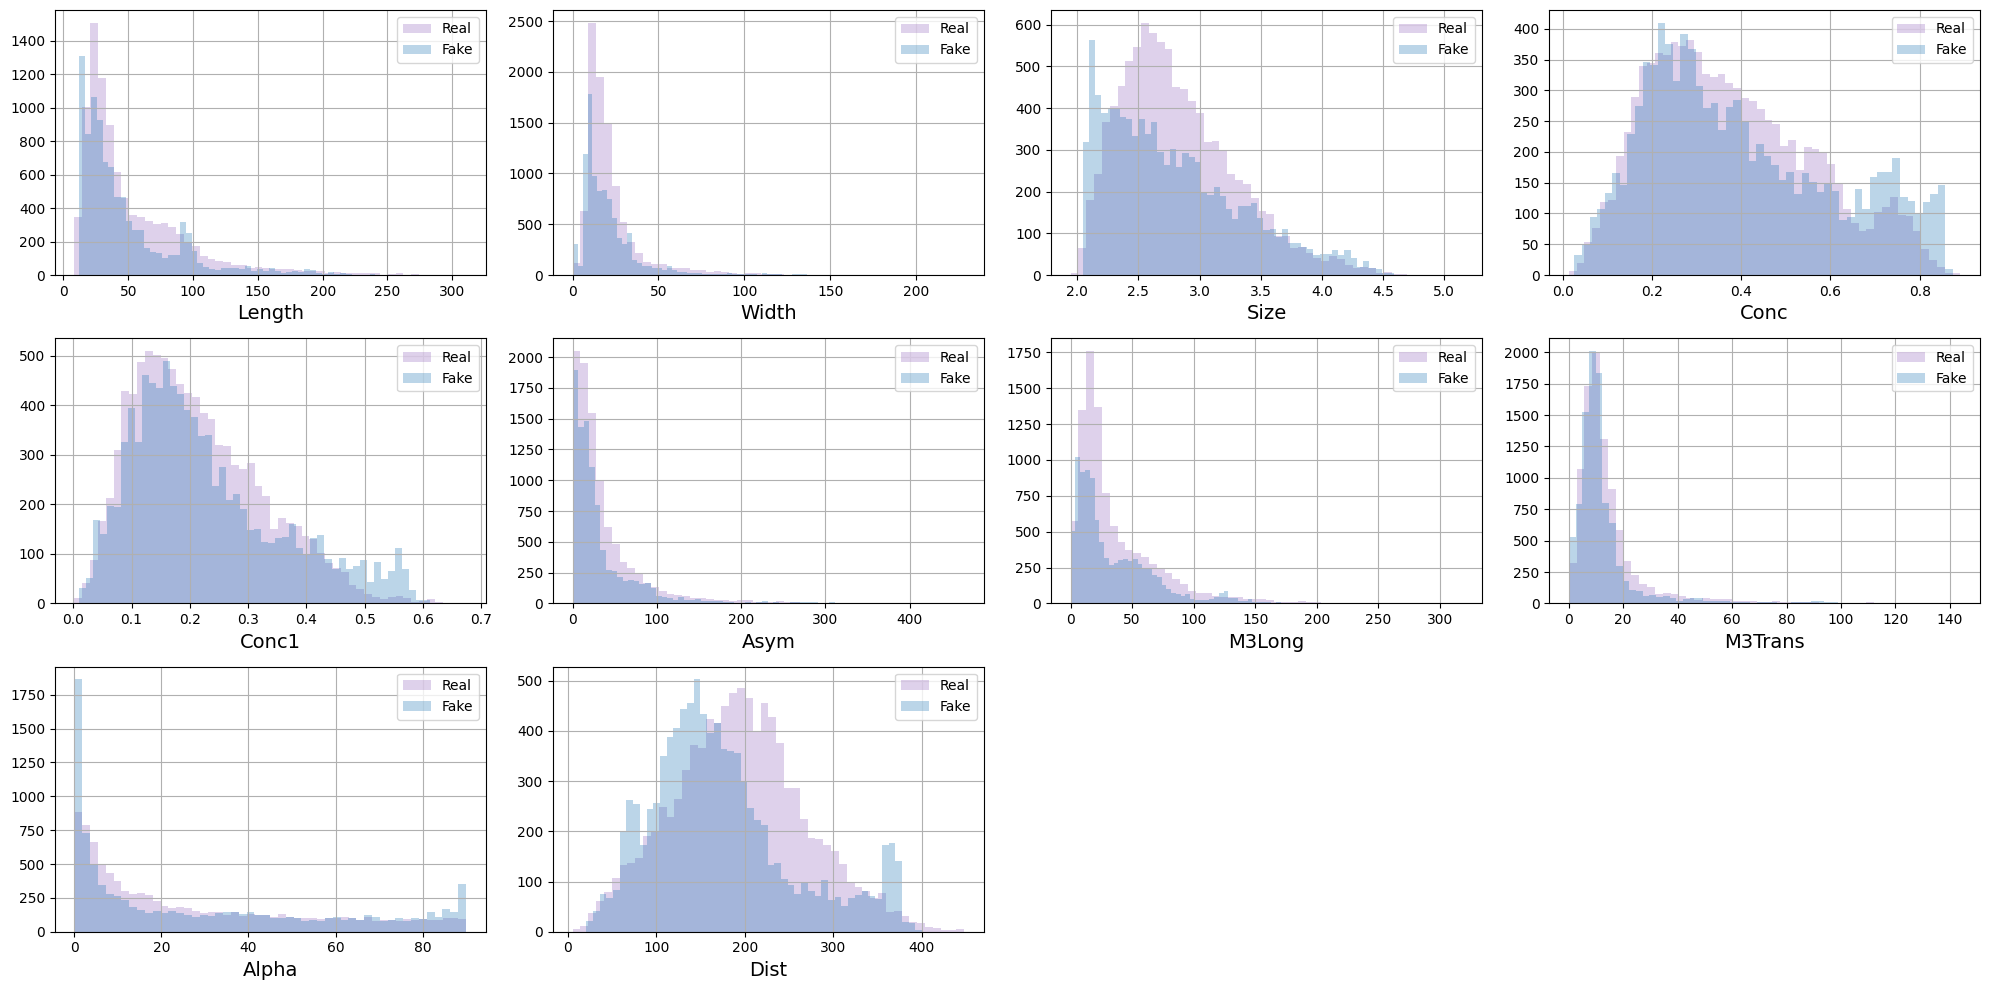

In [ ]:
plot_hists(X_test_original, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

auc = roc_auc_score(yy_test, yy_test_proba)
acc = accuracy_score(yy_test, np.round(yy_test_proba))
print("ROC AUC = ", auc)
print("ACCURACY = ", auc)

ROC AUC =  0.8955247395790141
ACCURACY =  0.8955247395790141


Результаты гораздо хуже, чем в GAN. Но думаю, что если добавить scheduler и timesteps в модель, то результат будет гораздо лучше. Я не успеваю это сделать, поэтому оставляю простую модель, которая в целом рабочая, это видно по картинкам распределений

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

Очень тяжело разбраться с новым материалом и с аппаратом, который сопровождается во время работы с диффузионками. Scheduler работал неверно у меня и у многих студентов из курса: roc auc = 1. В нем есть тонкости, которые не раскрыты на семинаре. А в самом семинаре модель с scheduler-ом используется по иному образу. Из-за этого не получилось добиться супер качества на диффузионке.

А так домашка суперинтересная, как и материалы курса в целом (кроме лекции по диффузиям - там вообще ничего не понятно, нет структуры и т. д.)